# Customer Scoring with RFM-Quartiles

Load data, bin RFM-values in quartiles, calculate cumulative score and condense (arbitrarily) to 4 segments. This is the easier variant of RFM-segmentation, but also the more unsophisticated. Either you have too many segments or you are losing valuable information on 'middle segment' customers if you mix all together in a cumulative score. I would try k-means first.

(A later comparision of the results for both methods at the end of the notebook shows the problem mentioned above. Both approaches identify the same 'gold' customers, but in the midlle segments there is some mix-up.)

This notebook owes a lot to Jiwon Jeong's blogpost [here](https://towardsdatascience.com/who-is-your-golden-goose-cohort-analysis-50c9de5dbd31). (Finally teached me how to properly group with multiple aggregations ...)



### Data Sources
- `data/interim/rfm_data.csv`: Transformed data from nb 1. A customer-level dataset wit recency, frequency, and monetary value columns.

### Data Output
- `data/processed/rfm_data_quartiles.csv`: Input data with k-means cluster column appended.

### Changes

- 2019-02-20: Start & Finish notebook


---

### Import libraries, load data

In [1]:
# Load libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import datetime as dt

from sklearn.preprocessing import StandardScaler

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

In [2]:
# Import data
rfm_data = pd.read_csv('data/interim/rfm_data.csv', index_col = 0)
rfm_data.drop('flag', axis=1, inplace=True)

In [3]:
rfm_data.head()

,sales,frequency,recency
CustomerID,,,
18102,233736.93,57,1
17450,192521.95,44,9
16446,168472.50,2,1
17511,87591.70,29,3
12346,77183.60,1,326


## 1) Bin Data in Quartiles (4 Groups) and Score Customers

In [4]:
# Create labels and assign them to tree percentile groups 
r_labels = range(4, 0, -1)
r_groups = pd.qcut(rfm_data['recency'], q = 4, labels = r_labels)
f_labels = range(1, 4)
f_groups = pd.qcut(rfm_data['frequency'], q = 4, labels = f_labels, duplicates= 'drop')
m_labels = range(1, 5)
m_groups = pd.qcut(rfm_data['sales'], q = 4, labels = m_labels)

**Note:** 

- `r_labels` is in descending order because recency means how much time has elapsed since a customer’s last order. Therefore the smaller the value is, the more engaged a customer to our business.
- `f_labels` has only 3 values, because a cut into four quartiles was not possible for `frequency`value. There are to many customers with frequency of 1.

In [6]:
# Append new columns to data
rfm = rfm_data.copy()
rfm['r_score'] = r_groups.values
rfm['f_score'] = f_groups.values
rfm['m_score'] = m_groups.values

# Sum up the three scores
rfm['rfm_segment'] = rfm.apply(lambda x: str(x['r_score']) + \
                               str(x['f_score']) + str(x['m_score']), axis=1)
rfm['rfm_score'] = np.sum(rfm[['r_score', 'f_score', 'm_score']], axis=1)

In [7]:
# Check results
display(rfm.head())

,sales,frequency,recency,r_score,f_score,m_score,rfm_segment,rfm_score
CustomerID,,,,,,,,
18102,233736.93,57,1,4,3,4,434,11.0
17450,192521.95,44,9,4,3,4,434,11.0
16446,168472.50,2,1,4,1,4,414,9.0
17511,87591.70,29,3,4,3,4,434,11.0
12346,77183.60,1,326,1,1,4,114,6.0


In [8]:
# Calculate averae values for each RFM-score
rfm_agg = pd.DataFrame(rfm.groupby('rfm_score').agg({
        'recency' : 'mean',
        'frequency' : 'mean',
        'sales' : ['mean', 'count']
        }))
display(rfm_agg.round(1))

recency frequency   sales      
             mean      mean    mean count
rfm_score                                
3.0         245.6       1.1   163.5   443
4.0         172.6       1.3   310.0   523
5.0          95.1       1.5   424.1   532
6.0          67.5       1.9   766.9   498
7.0          54.9       2.7  1095.9   410
8.0          41.9       3.8  1348.0   409
9.0          29.4       5.1  2372.0   335
10.0         20.4       7.7  3344.5   304
11.0          7.5      15.6  8343.9   408

## 2) Consolidate to 4 segments, save to disc

In [9]:
# Assign labels from total score
score_labels = ['Tin', 'Bronze', 'Silver', 'Gold']
score_groups = pd.qcut(rfm['rfm_score'], q = 4, labels = score_labels)
rfm['rfm_level'] = score_groups.values

In [10]:
# Check results
display(rfm.head())

,sales,frequency,recency,r_score,f_score,m_score,rfm_segment,rfm_score,rfm_level
CustomerID,,,,,,,,,
18102,233736.93,57,1,4,3,4,434,11.0,Gold
17450,192521.95,44,9,4,3,4,434,11.0,Gold
16446,168472.50,2,1,4,1,4,414,9.0,Silver
17511,87591.70,29,3,4,3,4,434,11.0,Gold
12346,77183.60,1,326,1,1,4,114,6.0,Bronze


In [11]:
rfm.drop(['r_score', 'f_score', 'm_score', 'rfm_score'], axis=1, inplace=True)
rfm.to_csv('data/processed/rfm_data_quartiles.csv')

---

# Bonus: Compare Results with k-means Clusters

In [12]:
# Import data
rfm_kmeans = pd.read_csv('data/processed/rfm_data_k-means.csv', index_col = 0)

In [13]:
# Log-transform and Scale data for better visibility 
rfm_log = cleaning.apply_log(rfm_kmeans, cols_to_transform=['frequency', 'recency', 'sales'], rename=True)
scaler = StandardScaler()
rfm_log_scaled = scaler.fit_transform(rfm_log[['sales_log', 
                                               'frequency_log', 
                                               'recency_log']])
rfm_log_scaled = pd.DataFrame(rfm_log_scaled, 
                              columns=rfm_log.columns[:3], 
                              index=rfm_data.index)

In [14]:
assert list(rfm_log_scaled.index) == list(rfm_kmeans.index) == list(rfm.index)

rfm_log_scaled['k_cluster'] = rfm_kmeans['k_cluster']
rfm_log_scaled['rfm_level'] = rfm['rfm_level']

In [15]:
for cluster in rfm_log_scaled['k_cluster'].unique():
    rfm_slice = rfm_log_scaled.loc[rfm_log_scaled['k_cluster'] == cluster]
    print('k-cluster: ', cluster)
    display(rfm_slice['rfm_level'].value_counts())

k-cluster:  2


Gold      596
Silver     53
Bronze      0
Tin         0
Name: rfm_level, dtype: int64

k-cluster:  0


Silver    824
Bronze    224
Gold      116
Tin         0
Name: rfm_level, dtype: int64

k-cluster:  1


Bronze    439
Silver    275
Tin         5
Gold        0
Name: rfm_level, dtype: int64

k-cluster:  3


Tin       961
Bronze    367
Silver      2
Gold        0
Name: rfm_level, dtype: int64

In [16]:
rfm_log_scaled['k_cluster'] = rfm_log_scaled['k_cluster'].map(
        {2: 'k_gold', 
         0: 'k_silver', 
         1: 'k_bronze',
         3: 'k_tin'})

### Compare with snake plots

In [17]:
# Melt the dataframe
rfm_log_scaled.reset_index(inplace=True)
rfm_melted = pd.melt(rfm_log_scaled, id_vars=['CustomerID', 'rfm_level', 'k_cluster'], 
                     var_name = 'metrics', value_name = 'value')

rfm_melted.head()

,CustomerID,rfm_level,k_cluster,metrics,value
0,18102,Gold,k_gold,sales_log,4.700606
1,17450,Gold,k_gold,sales_log,4.544186
2,16446,Silver,k_gold,sales_log,4.436590
3,17511,Gold,k_gold,sales_log,3.909172
4,12346,Bronze,k_silver,sales_log,3.807170


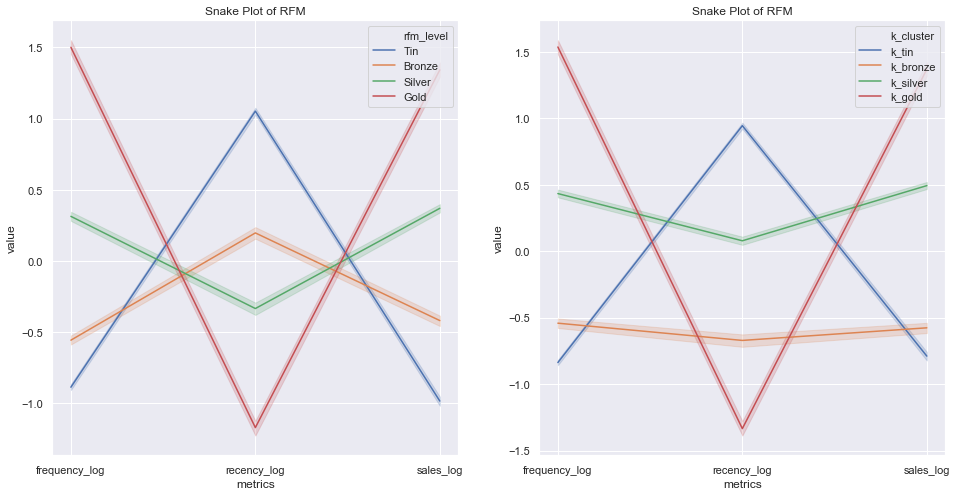

In [18]:
plt.figure(figsize=(16,8))
order_list = ['k_tin', 'k_bronze', 'k_silver', 'k_gold']

# Snake plot with RFM
plt.subplot(1, 2, 1)
sns.lineplot(x = 'metrics', y = 'value', hue = 'rfm_level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')
# a snake plot with K-Means
plt.subplot(1, 2, 2)
sns.lineplot(x = 'metrics', y = 'value', hue = 'k_cluster', hue_order=order_list, data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right');

**Observation:** Main difference in middle segments, mainly concerning recency.

### Compare with heatmap

In [47]:
# Calculate the mean values in total 
total_avg = np.mean(rfm_log_scaled.iloc[:, 1:4])*100000000000000  # why the hell???
print(total_avg)

sales_log        0.197805
frequency_log   -0.346590
recency_log      0.220423
dtype: float64


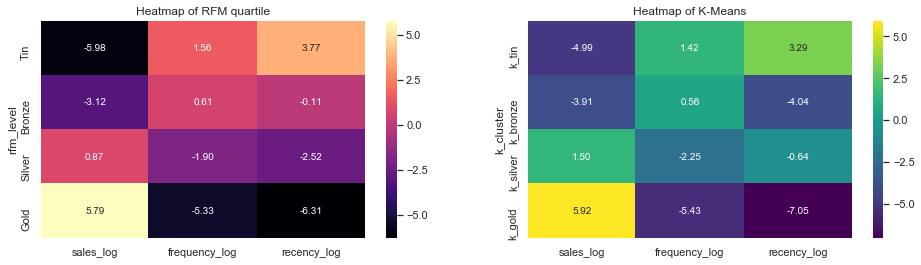

In [50]:
plt.figure(figsize=(16,4))

# Quartiles: Calculate the proportional gap with total mean
cluster_avg = rfm_log_scaled.groupby('rfm_level').mean().iloc[:, 1:4]
prop_rfm = cluster_avg / total_avg - 1

# Plot heatmap with RFM
plt.subplot(1, 2, 1)
sns.heatmap(prop_rfm, cmap='magma', fmt='.2f', annot=True)
plt.title('Heatmap of RFM quartile')

# K-means: calculate the proportional gap with total mean
cluster_avg_K = rfm_log_scaled.groupby('k_cluster').mean().iloc[:, 1:4]
prop_rfm_K = cluster_avg_K / total_avg - 1

# Plot heatmap with K-means
plt.subplot(1, 2, 2)
prop_rfm_K = prop_rfm_K.reindex(index=order_list)
sns.heatmap(prop_rfm_K, cmap= 'viridis', fmt='.2f', annot=True)
plt.title('Heatmap of K-Means');

**Observation:** The same pattern as above, but harder to read.

---